# Visual Object Tracking using Kalman Filter and SiamMask
This notebook compares a classical Kalman Filter and a deep SiamMask tracker on VOT2018 sequences (*butterfly* and *helicopter*). Evaluation is based on frame-wise IoU against ground truth.


## Download Dataset
> ⚠️ Note: The installation step was provided in the assignment instructions to work around issues with the PyPI `vot-toolkit` package.

The `vot-toolkit` package on pypi appears to be broken so use this patch and install it from source instead.

In [1]:
!pip install git+https://github.com/saeejithnair/toolkit.git

  Cloning https://github.com/saeejithnair/toolkit.git to /tmp/pip-req-build-z1tng2z3
  Running command git clone --filter=blob:none --quiet https://github.com/saeejithnair/toolkit.git /tmp/pip-req-build-z1tng2z3
  Resolved https://github.com/saeejithnair/toolkit.git to commit 2444f741908478439dd1e40c0137be3576ebc102
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 18.3 MB/s eta 0:00:00
  Created wheel for vot-toolkit: filename=vot_toolkit-0.7.1-py3-none-any.whl size=218766 sha256=be3dce053688a0590ed9a8c3c98ae5f8645bcde63d8a469267c5d68f1f5e6028
  Stored in directory: /tmp/pip-ephem-wheel-cache-v2d_gadv/wheels/a6/19/be/f0509df3754a8678c0e45d0f536ab97c122ea7c8c507d6a602
  Created wheel for attributee: filename=attributee-0.1.9-py3-none-any.whl size=13147 sha256=1fb5

In [10]:
!vot initialize

Workspace already initialized


In [5]:
!mkdir -p dataset/vot18st
!vot initialize vot2018/shortterm --workspace dataset/vot18st

Successfully downloaded all sequences.                                      
Download completed
Initialized workspace in 'dataset/vot18st'


In [6]:
!ls dataset/vot18st/sequences
!ls dataset/vot18st/sequences/butterfly

ants1	    book	  fish1        gymnastics3  motocross2	 soccer2
ants3	    butterfly	  fish2        hand	    nature	 soldier
bag	    car1	  fish3        handball1    pedestrian1  tiger
ball1	    conduction1   flamingo1    handball2    rabbit	 traffic
ball2	    crabs1	  frisbee      helicopter   racing	 wiper
basketball  crossing	  girl	       iceskater1   road	 zebrafish1
birds1	    dinosaur	  glove        iceskater2   shaking
blanket     drone1	  godfather    leaves	    sheep
bmx	    drone_across  graduate     list.txt     singer2
bolt1	    drone_flip	  gymnastics1  matrix	    singer3
bolt2	    fernando	  gymnastics2  motocross1   soccer1
camera_motion.tag  illum_change.tag   practical.value
color		   motion_change.tag  sequence
groundtruth.txt    occlusion.tag      size_change.tag


## Part 1: Kalman Filter Tracking (Butterfly)

In [43]:
!pip install pandas

For the **helicopter** sequence:

- `kf_output_folder`: changed from `"kf_butterfly_tracking"` to `"kf_helicopter_tracking"`
- `sequence_dir`: changed from `"dataset/vot18st/sequences/butterfly"` to `"dataset/vot18st/sequences/helicopter"`
- `output_video_path`: set to `"helicopter_tracking.avi"` to save the visualized result

I adjusted the Kalman Filter parameters for analysis:

- In `Q = np.eye(8) * 0.1`, I tested values: **0.001**, **0.01**, **0.1**, **1**
- In `R = np.diag([10, 10, 10, 10])`, I tested values: **1**, **10**, **50**, **100**


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import time

# Start timing
start_time = time.time()

# Create output folder for frames
kf_output_folder = "kf_butterfly_tracking"
os.makedirs(kf_output_folder, exist_ok=True)


def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    unionArea = boxAArea + boxBArea - interArea

    return interArea / unionArea if unionArea > 0 else 0

def parse_groundtruth(gt_file):
    with open(gt_file, 'r') as f:
        lines = f.readlines()
    gt_boxes = [np.array(list(map(float, line.strip().split(',')))).reshape(4, 2) for line in lines]
    return gt_boxes

def load_butterfly_sequence(sequence_dir):
    color_dir = os.path.join(sequence_dir, "color")
    image_files = sorted([os.path.join(color_dir, f) for f in os.listdir(color_dir) if f.endswith(".jpg")])
    gt_file = os.path.join(sequence_dir, "groundtruth.txt")
    gt_polygons = parse_groundtruth(gt_file)
    gt_boxes = []
    for poly in gt_polygons:
        x_min, y_min = np.min(poly, axis=0)
        x_max, y_max = np.max(poly, axis=0)
        gt_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])
    return image_files, np.array(gt_boxes)

def predict_state(x, P, F, Q):
    x_pred = np.dot(F,x) # Predict state
    P_pred = np.dot(F, np.dot(P, F.T)) + Q # Predict covariance
    return x_pred, P_pred

def update_state(x_pred, P_pred, z, H, R):
    # Innovation: Difference between measurement and prediction
    y = z - np.dot(H, x_pred)

    # Innovation covariance
    S = np.dot(H, np.dot(P_pred,H.T))+R

    # Kalman gain
    K = np.dot(P_pred,np.dot(H.T, np.linalg.inv(S)))

    # Updated state
    x_updated = x_pred + np.dot(K, y)

    # Updated covariance
    I = np.eye(x_pred.shape[0]) # Identity matrix of size 8x8
    P_updated = np.dot((I- np.dot(K, H)), P_pred)

    return x_updated, P_updated

# Load Butterfly Sequence
sequence_dir = "dataset/vot18st/sequences/butterfly"
image_files, gt_boxes = load_butterfly_sequence(sequence_dir)

# Initialize Kalman Filter
x = np.array([*gt_boxes[0], 0, 0, 0, 0], dtype=np.float32)
P = np.diag([500, 500, 500, 500, 50, 50, 50, 50])

# Process noise, measurement noise, and matrices
Q = np.eye(8) * 0.1
R = np.diag([10, 10, 10, 10])

# Kalman Filter Setup
dt = 1
F = np.eye(8)
for i in range(4):
    F[i, i+4] = dt
H = np.eye(4, 8)

# Define video output parameters
output_video = "butterfly_tracking.avi"
fps = 30  # Frames per second

# Get frame size from the first image
frame_sample = cv2.imread(image_files[0])
frame_height, frame_width = frame_sample.shape[:2]

# Initialize VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))

# Store IoU values for analysis
iou_values = []
detection_interval = 1 

# Loop through frames
for i, img_path in enumerate(image_files):
    frame = cv2.imread(img_path)
    if frame is None:
        print(f"Error: Could not read frame {i+1}")
        continue

    # Prediction always happens
    x_pred, P_pred = predict_state(x, P, F, Q)

    # Sparse update
    if i % detection_interval == 0:
        z = gt_boxes[i]
        x, P = update_state(x_pred, P_pred, z, H, R)
    else:
        x = x_pred
        P = P_pred

    # Draw boxes
    gt_x, gt_y, gt_w, gt_h = map(int, gt_boxes[i]) 
    pred_x, pred_y, pred_w, pred_h = map(int, x[:4])

    cv2.rectangle(frame, (gt_x, gt_y), (gt_x + gt_w, gt_y + gt_h), (0, 255, 0), 2)      # Green GT
    cv2.rectangle(frame, (pred_x, pred_y), (pred_x + pred_w, pred_y + pred_h), (0, 0, 255), 2)  # Red KF

    # Compute IoU
    iou = compute_iou(gt_boxes[i], x[:4])
    iou_values.append([i + 1, iou])

    # Draw text
    cv2.putText(frame, "Kalman Filter Prediction", (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(frame, "Ground Truth", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(frame, f"IoU: {iou:.3f}", (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    # Save + display
    video_writer.write(frame)
    cv2.imwrite(os.path.join(kf_output_folder, f"frame_{i:04d}.jpg"), frame)
    print(f"Writing frame {i+1}/{len(image_files)}")

    cv2.imshow("butterfly Tracking", frame) #butterfly / helicopter
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# End timing
end_time = time.time()
total_time = end_time - start_time
fps = len(image_files) / total_time

print(f"\nTotal runtime: {total_time:.2f} seconds")
print(f"Approximate FPS: {fps:.2f} frames/second")

# Release resources
video_writer.release()
cv2.destroyAllWindows()

print(f"Video saved as {output_video}")

# Extract key values from Q and R for filename
q_value = Q[0, 0]
r_value = R[0, 0] 

# Convert to DataFrame and save
iou_df = pd.DataFrame(iou_values, columns=["Frame", "IoU"])
iou_csv_path = f"iou_tracking_R_{r_value:.3f}_Q_{q_value:.3f}.csv"
iou_df.to_csv(iou_csv_path, index=False)
print(f"IoU results saved as {iou_csv_path}")


Writing frame 1/151
Writing frame 2/151
Writing frame 3/151
Writing frame 4/151
Writing frame 5/151
Writing frame 6/151
Writing frame 7/151
Writing frame 8/151
Writing frame 9/151
Writing frame 10/151
Writing frame 11/151
Writing frame 12/151
Writing frame 13/151
Writing frame 14/151
Writing frame 15/151
Writing frame 16/151
Writing frame 17/151
Writing frame 18/151
Writing frame 19/151
Writing frame 20/151
Writing frame 21/151
Writing frame 22/151
Writing frame 23/151
Writing frame 24/151
Writing frame 25/151
Writing frame 26/151
Writing frame 27/151
Writing frame 28/151
Writing frame 29/151
Writing frame 30/151
Writing frame 31/151
Writing frame 32/151
Writing frame 33/151
Writing frame 34/151
Writing frame 35/151
Writing frame 36/151
Writing frame 37/151
Writing frame 38/151
Writing frame 39/151
Writing frame 40/151
Writing frame 41/151
Writing frame 42/151
Writing frame 43/151
Writing frame 44/151
Writing frame 45/151
Writing frame 46/151
Writing frame 47/151
Writing frame 48/151
W

### IoU comparison graphs using CSV files

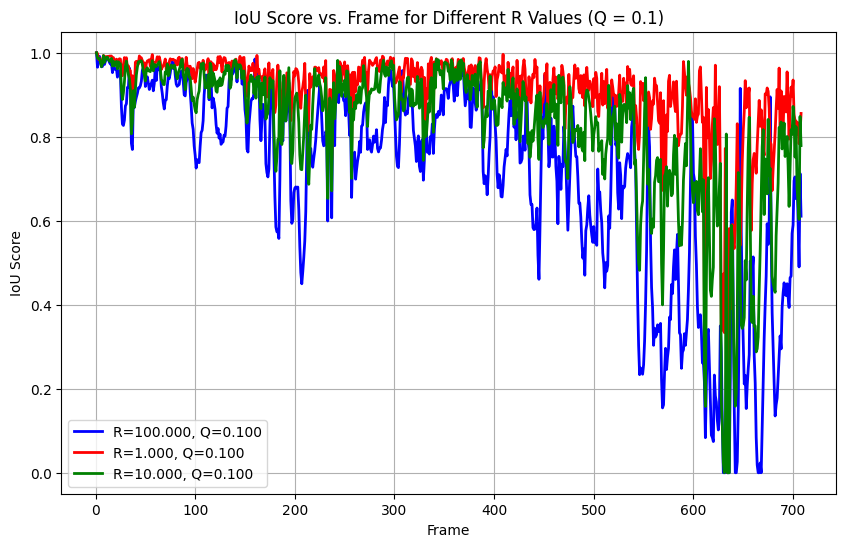

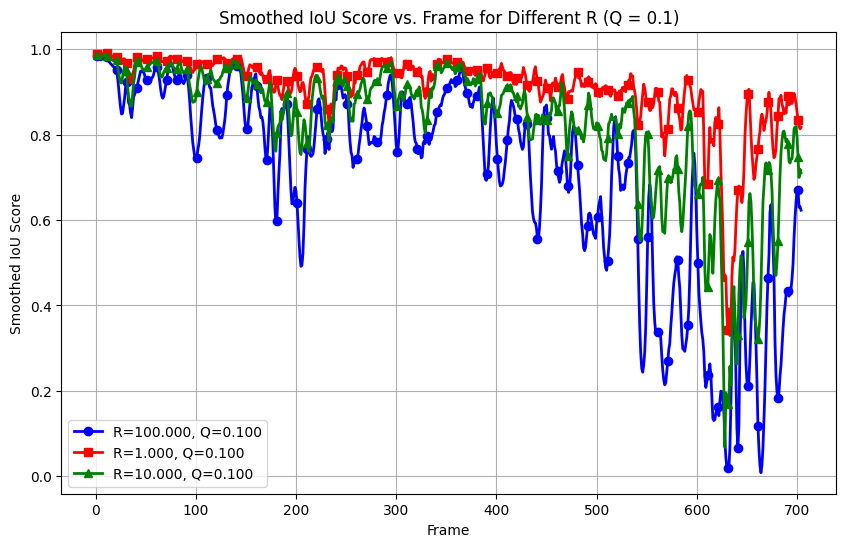

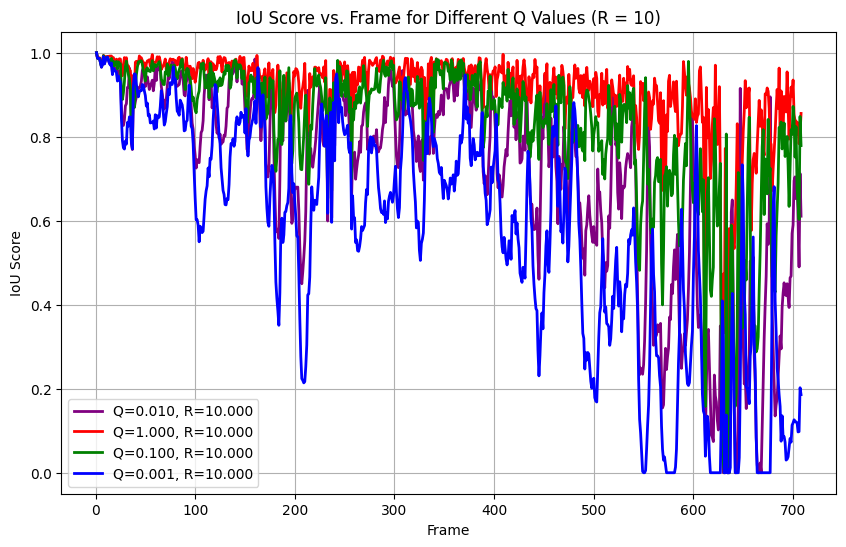

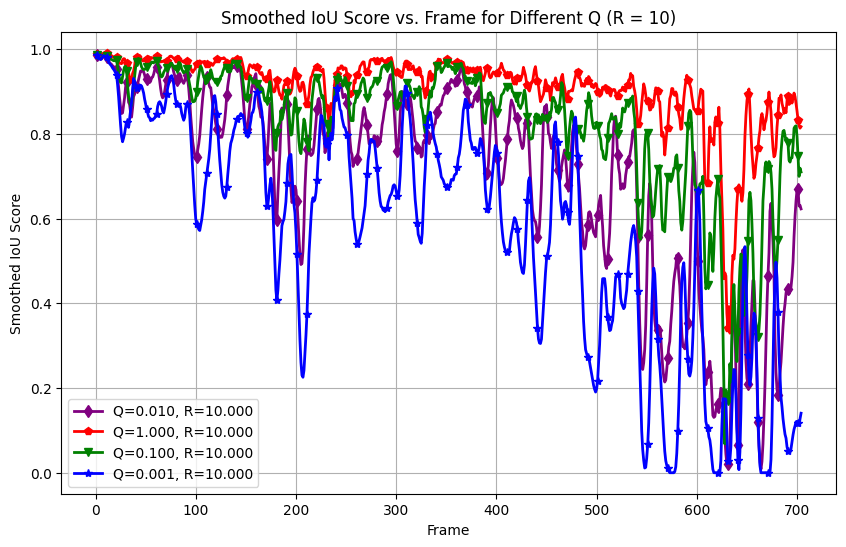

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

# Moving average function
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# ---------- Part 1: Different R (Q = 0.1) ----------
csv_files_r = glob.glob("iou_tracking_R_*.csv")
colors = ["b", "r", "g", "orange", "purple"]
markers = ["o", "s", "^", "D", "*"]

# Plot 1: Raw IoU for different R
plt.figure(figsize=(10,6))
for idx, file in enumerate(csv_files_r):
    df = pd.read_csv(file)
    Q_value = file.split("_Q_")[1].split(".csv")[0]
    R_value = file.split("_R_")[1].split("_Q_")[0]
    plt.plot(df["Frame"], df["IoU"], label=f"R={R_value}, Q={Q_value}",
             color=colors[idx % len(colors)], linewidth=2)
plt.xlabel("Frame")
plt.ylabel("IoU Score")
plt.title("IoU Score vs. Frame for Different R Values (Q = 0.1)")
plt.legend()
plt.grid()
plt.savefig("helicopter_kf_iou_R.png", dpi=300)
plt.show()

# Plot 2: Smoothed IoU for different R
plt.figure(figsize=(10,6))
for idx, file in enumerate(csv_files_r):
    df = pd.read_csv(file)
    Q_value = file.split("_Q_")[1].split(".csv")[0]
    R_value = file.split("_R_")[1].split("_Q_")[0]
    smoothed_iou = moving_average(df["IoU"], window_size=5)
    frames = df["Frame"][:len(smoothed_iou)]
    plt.plot(frames, smoothed_iou, label=f"R={R_value}, Q={Q_value}", 
             color=colors[idx % len(colors)], marker=markers[idx % len(markers)], 
             markevery=10, linewidth=2)
plt.xlabel("Frame")
plt.ylabel("Smoothed IoU Score")
plt.title("Smoothed IoU Score vs. Frame for Different R (Q = 0.1)")
plt.legend()
plt.grid()
plt.savefig("helicopter_kf_smooth_iou_R.png", dpi=300)
plt.show()



# ---------- Part 2: Different Q (R = 10) ----------
csv_files_q = glob.glob("iou_tracking_Q_*_R_10.000.csv")
colors_q = ["purple", "red", "green", "blue", "orange"]
markers_q = ["d", "p", "v", "*", "h"]

# Plot 3: Raw IoU for different Q
plt.figure(figsize=(10,6))
for idx, file in enumerate(csv_files_q):
    df = pd.read_csv(file)
    Q_value = file.split("_Q_")[1].split("_R_")[0]
    R_value = file.split("_R_")[1].split(".csv")[0]
    plt.plot(df["Frame"], df["IoU"], label=f"Q={Q_value}, R={R_value}",
             color=colors_q[idx % len(colors_q)], linewidth=2)
plt.xlabel("Frame")
plt.ylabel("IoU Score")
plt.title("IoU Score vs. Frame for Different Q Values (R = 10)")
plt.legend()
plt.grid()
plt.savefig("helicopter_kf_iou_Q.png", dpi=300)
plt.show()

# Plot 4: Smoothed IoU for different Q
plt.figure(figsize=(10,6))
for idx, file in enumerate(csv_files_q):
    df = pd.read_csv(file)
    Q_value = file.split("_Q_")[1].split("_R_")[0]
    R_value = file.split("_R_")[1].split(".csv")[0]
    smoothed_iou = moving_average(df["IoU"], window_size=5)
    frames = df["Frame"][:len(smoothed_iou)]
    plt.plot(frames, smoothed_iou, label=f"Q={Q_value}, R={R_value}", 
             color=colors_q[idx % len(colors_q)], marker=markers_q[idx % len(markers_q)], 
             markevery=10, linewidth=2)
plt.xlabel("Frame")
plt.ylabel("Smoothed IoU Score")
plt.title("Smoothed IoU Score vs. Frame for Different Q (R = 10)")
plt.legend()
plt.grid()
plt.savefig("helicopter_kf_smooth_iou_Q.png", dpi=300)
plt.show()


### Compute tracking statistics

In [ ]:
import pandas as pd
import numpy as np

# Path to IoU CSV file
csv_path = "./iou_tracking_R_10.000_Q_0.100.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Extract IoU values
iou_values = df["IoU"].tolist()

# Compute tracking statistics
average_iou = np.mean(iou_values)
std_iou = np.std(iou_values)
min_iou = np.min(iou_values)
max_iou = np.max(iou_values)
acceptable_frames = sum(i >= 0.7 for i in iou_values)
total_frames = len(iou_values)
acceptable_ratio = acceptable_frames / total_frames

# Print report
print("\nKalman Filter IoU Summary for:")
print(f"File: {csv_path}")
print(f"Average IoU: {average_iou:.4f}")
print(f"Standard Deviation: {std_iou:.4f}")
print(f"Minimum IoU: {min_iou:.4f}")
print(f"Maximum IoU: {max_iou:.4f}")
print(f"Frames with IoU ≥ 0.7: {acceptable_frames} / {total_frames} ({acceptable_ratio*100:.1f}%)")



Kalman Filter IoU Summary for:
File: ~/tracking/iou_tracking_R_10.000_Q_0.100.csv
Average IoU: 0.7297
Standard Deviation: 0.1370
Minimum IoU: 0.3248
Maximum IoU: 1.0000
Frames with IoU ≥ 0.7: 103 / 151 (68.2%)


## Part 2: SiamMask Tracking (Helicopter)
### SiamMask Environment Setup

In [ ]:
!git clone https://github.com/foolwood/SiamMask.git
!cd SiamMask && bash make.sh
!mkdir -p SiamMask/pretrain
!wget http://www.robots.ox.ac.uk/~qwang/SiamMask_VOT.pth -O SiamMask/pretrain/SiamMask_VOT.pth

Cloning into 'SiamMask'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 270 (delta 0), reused 0 (delta 0), pack-reused 267 (from 1)
Receiving objects: 100% (270/270), 6.91 MiB | 12.57 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Traceback (most recent call last):
  File "/home/simon/tracking/SiamMask/utils/pyvotkit/setup.py", line 11, in <module>
    from Cython.Build import cythonize
ModuleNotFoundError: No module named 'Cython'
Traceback (most recent call last):
  File "/home/simon/tracking/SiamMask/utils/pysot/utils/setup.py", line 11, in <module>
    from Cython.Build import cythonize
ModuleNotFoundError: No module named 'Cython'
--2025-03-20 10:23:54--  http://www.robots.ox.ac.uk/~qwang/SiamMask_VOT.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awai

```bash
conda create -n siammask python=3.6
conda activate siammask
wget https://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
pip install -r requirements.txt
bash make.sh
export PYTHONPATH=$PWD:$PYTHONPATH

In [1]:
import torch
print(torch.__version__)


2.5.1


### SiamMask Tracking on Helicopter Sequence

The current script is configured for the **helicopter** sequence using SiamMask.

To adapt the script for the **butterfly** sequence, modify the following parameters:

- `output_folder`: change from `"siam_helicopter_tracking_output"` to `"siam_butterfly_tracking_output"`
- `base_path`: change from `"dataset/vot18st/sequences/helicopter/color/"` to `"dataset/vot18st/sequences/butterfly/color/"`
- `output_video_path`: change from `"helicopter_siam.avi"` to `"butterfly_siam.avi"`

[2025-03-22 05:31:34,625-rk0-features.py# 66] Current training 0 layers:
	
[2025-03-22 05:31:34,626-rk0-features.py# 66] Current training 1 layers:
	
[2025-03-22 05:31:34,674-rk0-load_helper.py# 31] load pretrained model from SiamMask/experiments/siammask_sharp/SiamMask_VOT.pth
[2025-03-22 05:31:34,696-rk0-load_helper.py# 25] remove prefix 'module.'
[2025-03-22 05:31:34,697-rk0-load_helper.py# 18] used keys:356


Processed frame 1/708
Processed frame 2/708
Processed frame 3/708
Processed frame 4/708
Processed frame 5/708
Processed frame 6/708
Processed frame 7/708
Processed frame 8/708
Processed frame 9/708
Processed frame 10/708
Processed frame 11/708
Processed frame 12/708
Processed frame 13/708
Processed frame 14/708
Processed frame 15/708
Processed frame 16/708
Processed frame 17/708
Processed frame 18/708
Processed frame 19/708
Processed frame 20/708
Processed frame 21/708
Processed frame 22/708
Processed frame 23/708
Processed frame 24/708
Processed frame 25/708
Processed frame 26/708
Processed frame 27/708
Processed frame 28/708
Processed frame 29/708
Processed frame 30/708
Processed frame 31/708
Processed frame 32/708
Processed frame 33/708
Processed frame 34/708
Processed frame 35/708
Processed frame 36/708
Processed frame 37/708
Processed frame 38/708
Processed frame 39/708
Processed frame 40/708
Processed frame 41/708
Processed frame 42/708
Processed frame 43/708
Processed frame 44/7

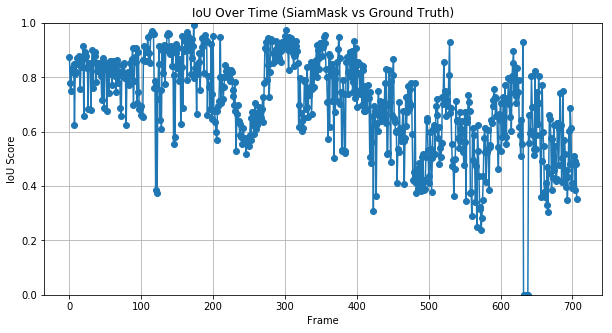

In [6]:
import os
import glob
import time
import argparse
import cv2
import torch
import numpy as np
from os.path import join, isfile
import sys
import time

sys.path.append("./SiamMask")

from SiamMask.tools.test import siamese_init, siamese_track
from SiamMask.utils.load_helper import load_pretrain
from SiamMask.utils.config_helper import load_config
from SiamMask.experiments.siammask_sharp.custom import Custom
from SiamMask.experiments.siammask_sharp.resnet import resnet50

# Start timing
start_time = time.time()

# Create output folder for frames
output_folder = "siam_helicopter_tracking_output"
os.makedirs(output_folder, exist_ok=True)

# Arguments for model and dataset
class Args:
    resume = "SiamMask/experiments/siammask_sharp/SiamMask_VOT.pth"
    config = "SiamMask/experiments/siammask_sharp/config_vot.json"
    base_path = "dataset/vot18st/sequences/helicopter/color/"
    cpu = False

args = Args()

device = torch.device('cuda' if torch.cuda.is_available() and not args.cpu else 'cpu')
torch.backends.cudnn.benchmark = True

# Load config and model
cfg = load_config(args)
model = Custom(anchors=cfg['anchors'])
assert isfile(args.resume), f"Checkpoint not found: {args.resume}"
model = load_pretrain(model, args.resume)
model.eval().to(device)

# Load images
img_files = sorted(glob.glob(join(args.base_path, '*.jp*')))
assert len(img_files) > 0, f"No images found in {args.base_path}"
frames = [cv2.imread(imf) for imf in img_files]

# Load ground truth bounding boxes
def parse_groundtruth(gt_file):
    with open(gt_file, 'r') as f:
        lines = f.readlines()
    gt_boxes = [np.array(list(map(float, line.strip().split(',')))).reshape(4, 2) for line in lines]
    return gt_boxes

sequence_dir = os.path.dirname(args.base_path)
gt_file = os.path.join(os.path.dirname(sequence_dir), 'groundtruth.txt')
gt_boxes = parse_groundtruth(gt_file)

# Initialize Video Writer
output_video_path = "helicopter_siam.avi"
frame_height, frame_width, _ = frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
fps = 20
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Function to compute IoU
def compute_iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[0] + boxA[2], boxB[0] + boxB[2]), min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    unionArea = boxA[2] * boxA[3] + boxB[2] * boxB[3] - interArea
    return interArea / unionArea if unionArea > 0 else 0

# Use first ground truth bounding box as initial ROI
gt_x_min, gt_y_min = np.min(gt_boxes[0], axis=0)
gt_x_max, gt_y_max = np.max(gt_boxes[0], axis=0)
init_rect = (gt_x_min, gt_y_min, gt_x_max - gt_x_min, gt_y_max - gt_y_min)
x, y, w, h = init_rect

# Tracking loop
iou_scores = []
for i, frame in enumerate(frames):
    start = time.time()
    
    if i == 0:
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(frame, target_pos, target_sz, model, cfg['hp'], device=device)
    else:
        state = siamese_track(state, frame, mask_enable=True, refine_enable=True, device=device)

        # Get predicted bounding box
        x_min, y_min = np.min(state['ploygon'], axis=0)
        x_max, y_max = np.max(state['ploygon'], axis=0)
        tracked_box = [x_min, y_min, x_max - x_min, y_max - y_min]

        # Draw predicted bounding box
        cv2.polylines(frame, [np.int0(state['ploygon']).reshape((-1, 1, 2))], True, (0, 0, 255), 3)

        # Draw ground truth bounding box
        if i < len(gt_boxes):
            gt_box = gt_boxes[i].astype(np.int32)
            cv2.polylines(frame, [gt_box.reshape((-1, 1, 2))], True, (0, 255, 0), 2)

            # Compute IoU
            gt_x_min, gt_y_min = np.min(gt_box, axis=0)
            gt_x_max, gt_y_max = np.max(gt_box, axis=0)
            gt_box_xywh = [gt_x_min, gt_y_min, gt_x_max - gt_x_min, gt_y_max - gt_y_min]
            iou = compute_iou(tracked_box, gt_box_xywh)
            iou_scores.append(iou)

            cv2.putText(frame, "SiamMask Prediction", (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            cv2.putText(frame, "Ground Truth", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(frame, f"IoU: {iou:.3f}", (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)


        # Save frame as image
        frame_path = join(output_folder, f"frame_{i:04d}.jpg")
        cv2.imwrite(frame_path, frame)

        # Write frame to video
        video_writer.write(frame)

    print(f"Processed frame {i+1}/{len(frames)}")

# End timing
end_time = time.time()
total_time = end_time - start_time
fps = len(img_files) / total_time

print(f"\nTotal runtime: {total_time:.2f} seconds")
print(f"Approximate FPS: {fps:.2f} frames/second")


# Release resources
video_writer.release()
cv2.destroyAllWindows()

print(f"Tracking saved as {output_video_path}")

import csv

# Define CSV output file
iou_csv_path = "iou_scores.csv"

# Write IoU scores to CSV
with open(iou_csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Frame", "IoU Score"])  # Header row
    for i, iou in enumerate(iou_scores):
        writer.writerow([i + 1, iou])  # Frame number starts from 1

print(f"IoU scores saved to {iou_csv_path}")

# Plot IoU scores
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(iou_scores, marker='o', linestyle='-')
plt.title("IoU Over Time (SiamMask vs Ground Truth)")
plt.xlabel("Frame")
plt.ylabel("IoU Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


### IoU comparision between Kalman Filter and SiamMask

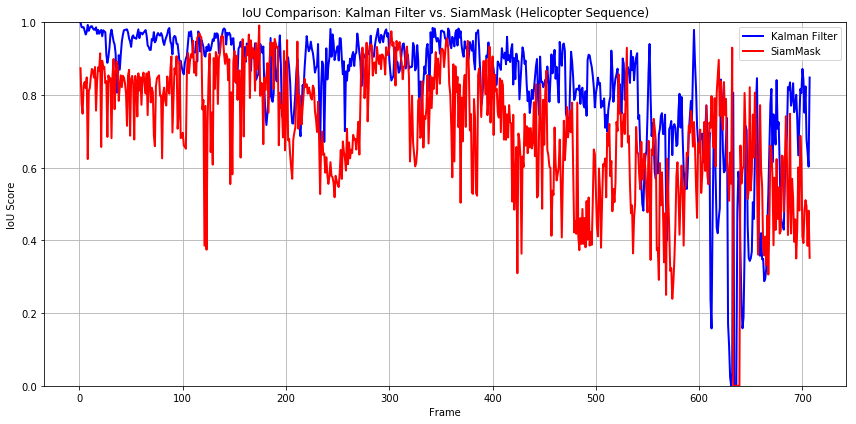

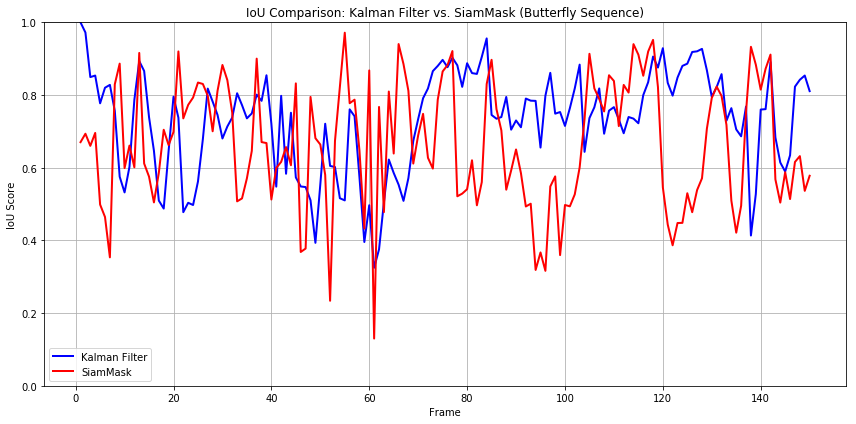

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load SiamMask IoU results
siam_df = pd.read_csv("./helicopter_iou/siam_helicopter_iou_scores.csv")
siam_df.columns = ["Frame", "IoU_Siam"]

# Load Kalman Filter IoU results
kf_df = pd.read_csv("./helicopter_iou/iou_tracking_R_10.000_Q_0.100.csv")
kf_df.columns = ["Frame", "IoU_KF"]

# Merge on Frame
merged_df = pd.merge(siam_df, kf_df, on="Frame", how="inner")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df["Frame"], merged_df["IoU_KF"], label="Kalman Filter", color="blue", linewidth=2)
plt.plot(merged_df["Frame"], merged_df["IoU_Siam"], label="SiamMask", color="red", linewidth=2)

plt.xlabel("Frame")
plt.ylabel("IoU Score")
plt.title("IoU Comparison: Kalman Filter vs. SiamMask (Helicopter Sequence)")
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("iou_comparison_helicopter.png", dpi=300)
plt.show()

# Load SiamMask IoU results
siam_df = pd.read_csv("./butterfly_iou/siam_butterfly_iou_scores.csv")
siam_df.columns = ["Frame", "IoU_Siam"]

# Load Kalman Filter IoU results
kf_df = pd.read_csv("./butterfly_iou/iou_tracking_R_10.000_Q_0.100.csv")
kf_df.columns = ["Frame", "IoU_KF"]

# Merge on Frame
merged_df = pd.merge(siam_df, kf_df, on="Frame", how="inner")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df["Frame"], merged_df["IoU_KF"], label="Kalman Filter", color="blue", linewidth=2)
plt.plot(merged_df["Frame"], merged_df["IoU_Siam"], label="SiamMask", color="red", linewidth=2)

plt.xlabel("Frame")
plt.ylabel("IoU Score")
plt.title("IoU Comparison: Kalman Filter vs. SiamMask (Butterfly Sequence)")
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("iou_comparison_butterfly.png", dpi=300)
plt.show()

